## Final Project
- Created by Achmad Fawaz Ferdiansyah
- PT. Berlian Sistem Informasi
- [Dataset](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)

Berdasarkan data customer ini, kita ingin melihat pengelompokkan orang-orang yang ada berdasarkan data yang tersedia seperti Penghasilan Tahunan dan Pengeluaran pada Supermarket ini.

Dengan melihat hasil pengelompokkannya tersebut, kita mampu memberikan program yang sesuai berdasarkan hasil pengelompokkannya agar dapat meningkatkan pemasukan yang ada pada Supermarket.

### Importing Library

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go


from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

### Data Loading & EDA

In [60]:
# pip install -q kaggle

In [61]:
# !mkdir ~/.kaggle #bikin direktori atau folder kaggle di root
# !cp /content/kaggle.json ~/.kaggle/
# !ls ~/.kaggle

In [62]:
# !chmod 600 /root/.kaggle/kaggle.json

In [63]:
# !kaggle datasets download -d vjchoudhary7/customer-segmentation-tutorial-in-python

In [64]:
# !unzip customer-segmentation-tutorial-in-python.zip -d dataset

In [65]:
df = pd.read_csv('/content/dataset/Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [67]:
df_copy = df.copy()

In [68]:
# Mengganti nama kolom agar mudah digunakan
df_copy = df_copy.rename(columns={'Annual Income (k$)': 'annual_income',
                       'Spending Score (1-100)': 'spending_score'})
df_copy.columns = df_copy.columns.str.lower()

# Mapping Male menjadi 0 dan Female menjadi 1
df_copy['gender'] = df_copy['gender'].map({'Male': 0, 'Female': 1})

df_copy.head()

,customerid,gender,age,annual_income,spending_score
0,1,0,19,15,39
1,2,0,21,15,81
2,3,1,20,16,6
3,4,1,23,16,77
4,5,1,31,17,40


In [69]:
df_copy.describe()

,customerid,gender,age,annual_income,spending_score
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,0.560000,38.850000,60.560000,50.200000
std,57.879185,0.497633,13.969007,26.264721,25.823522
min,1.000000,0.000000,18.000000,15.000000,1.000000
25%,50.750000,0.000000,28.750000,41.500000,34.750000
50%,100.500000,1.000000,36.000000,61.500000,50.000000
75%,150.250000,1.000000,49.000000,78.000000,73.000000
max,200.000000,1.000000,70.000000,137.000000,99.000000


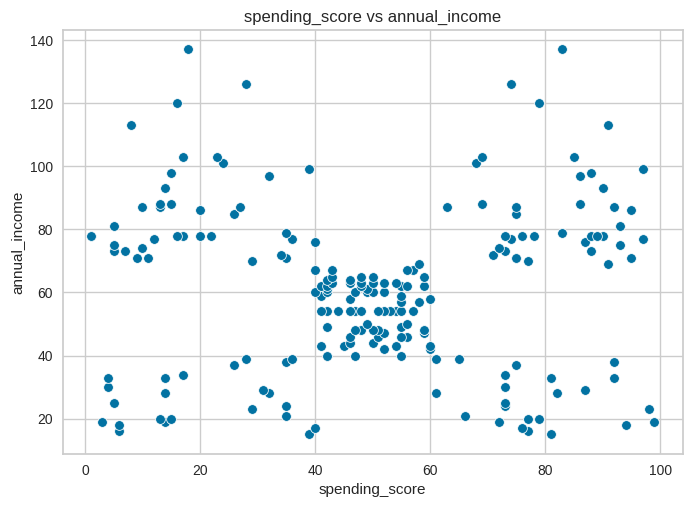

In [70]:
sns.scatterplot(data=df_copy,x='spending_score', y='annual_income')
plt.title('spending_score vs annual_income');

Data ini merupakan data perbandingan antara pengeluaran dan pemasukan yang ada pada supermarket. Namun, kita masih belum bisa melihat pengelompokan yang ada pada data tersebut. Sehingga, kita membutuhkan Machine Learning Unsupervised yang bertujuan untuk ***clustering***

In [71]:
num_cols= ['age', 'annual_income', 'spending_score']
cat_cols= ['gender']

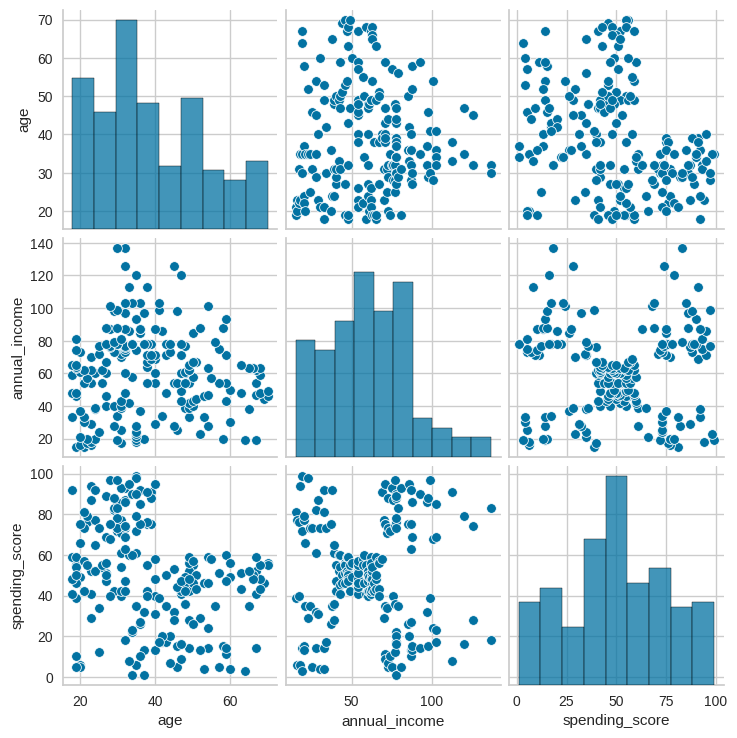

In [72]:
sns.pairplot(df_copy[num_cols]);

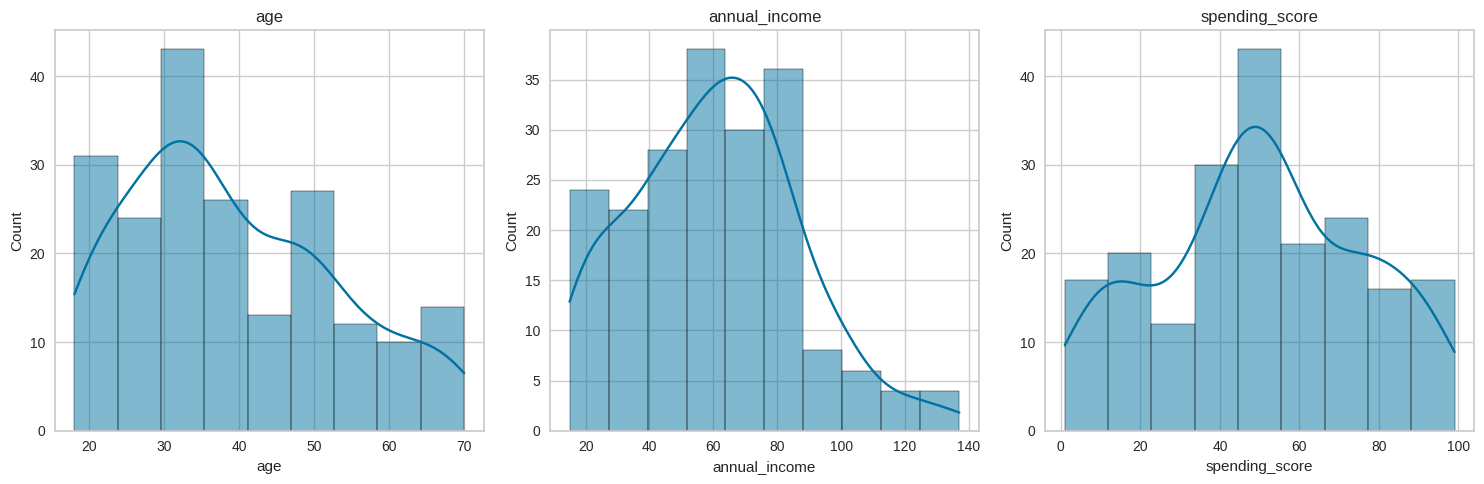

In [73]:
# atur figure dan axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot histograms dgn KDE
for i, column in enumerate(['age', 'annual_income', 'spending_score']):
    sns.histplot(data=df_copy, x=column, kde=True, ax=axes[i])
    axes[i].set_title(column)

# Display plot
plt.tight_layout() # secara otomatis mengoptimalkan ruang di antara subplot agar tidak ada tumpang tindih
plt.show()

Data yang ada pada dataset umumnya memiliki skewness kecuali pada spending score dimana data tersebut terdistribusi secara normal. Sehingga apabila data pengeluaran dijadikan acuan, hal ini sudah dapat dilakukan untuk memahami segala kasus-kasus yang terjadi.

In [74]:
# Menghitung jumlah setiap kategori gender
gender_counts = df_copy['gender'].value_counts().reset_index()
gender_counts.columns = ['gender', 'count']
gender_counts

,gender,count
0,1,112
1,0,88


In [75]:
# Membuat pie chart dengan Plotly Express
fig = go.Figure(data=[go.Pie(labels=['Female','Male'], values=gender_counts['count'])])

# Mengatur posisi title dan legend
fig.update_layout(title_text='Persentase Gender', title_x=0.5, title_y=0.95,
                  legend=dict(x=0.9, y=0.5))

fig.show()

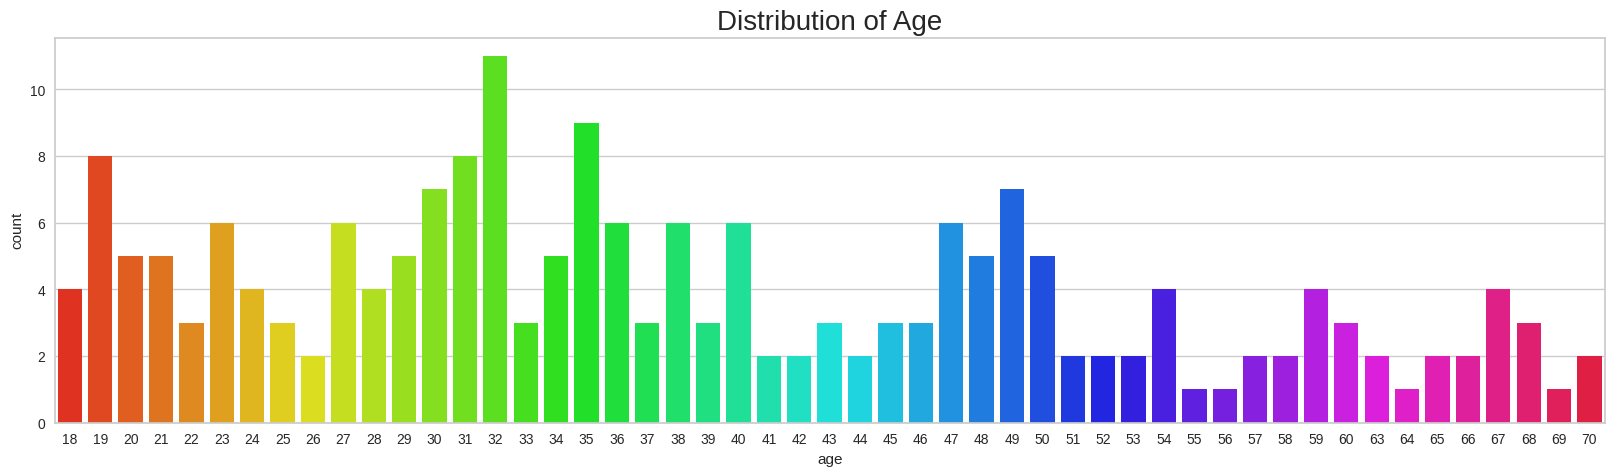

In [76]:
plt.figure(figsize=(20,5))
sns.countplot(x=df_copy['age'], palette = 'hsv')
plt.title('Distribution of Age', fontsize = 20)
plt.show()

Data yang dijadikan dataset memiliki persebaran umur yang cukup beragam, dari umur 18 tahun hingga 70 tahun dengan data terbanyak ada pada umur dikisaran 30an.

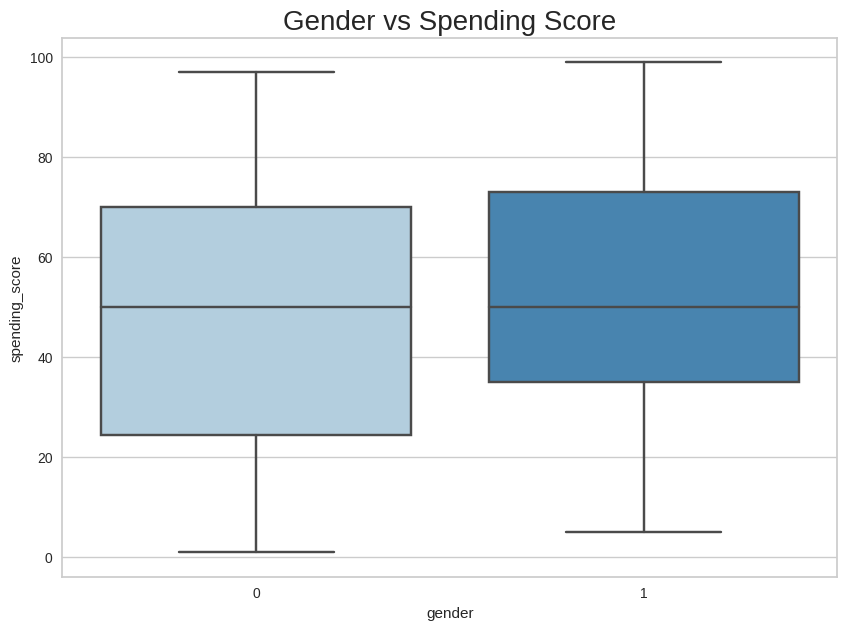

In [77]:
#  Gender vs Spendscore
plt.figure(figsize=(10,7))
sns.boxplot(data=df_copy, x= 'gender', y= 'spending_score', palette='Blues')
plt.title('Gender vs Spending Score', fontsize = 20)
plt.show()

### Preprocessing & Modelling

#### Creating Inference Data with Random Number

In [78]:
df_inter = pd.DataFrame()
df_inter['age'] = np.random.randint(low=18, high=47, size=(140))
df_inter['annual_income'] = np.random.randint(low=15, high=137, size=(140))
df_inter['spending_score'] = np.random.randint(low=1, high=99, size=(140))

In [79]:
df_inter

,age,annual_income,spending_score
0,22,27,91
1,21,38,22
2,25,21,9
3,43,26,97
4,37,59,20
...,...,...,...
135,46,56,75
136,36,21,35
137,20,121,20
138,33,135,4


#### Model : Clustering without PCA

In [80]:
x = df_copy.loc[:, ['spending_score', 'annual_income']]

print(x.shape)

(200, 2)


In [81]:
x

,spending_score,annual_income
0,39,15
1,81,15
2,6,16
3,77,16
4,40,17
...,...,...
195,79,120
196,28,126
197,74,126
198,18,137


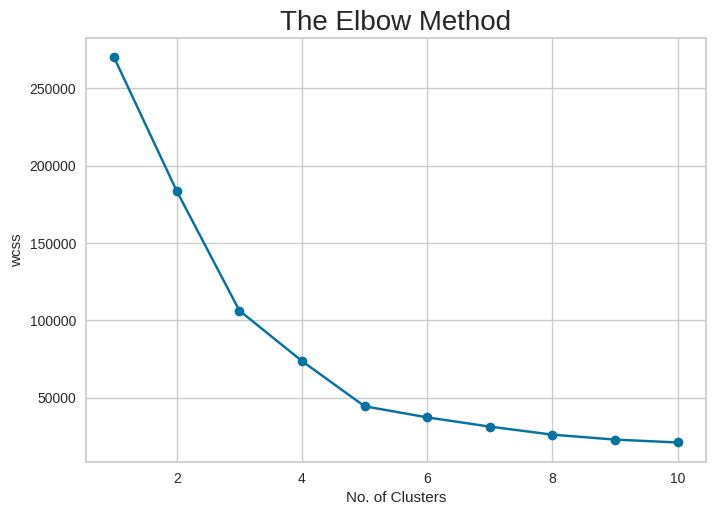

In [82]:
wcss = []
#membuat iterasi dari 1-10 untuk nilai k terbaik
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 'auto', random_state = 3)
    km.fit(x)
    wcss.append(km.inertia_)

plt.plot(range(1, 11), wcss, marker ="o")
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

Berdasarkan hasil Elbow Method, didapatkan jumlah cluster yang paling efektif untuk menggambarkan pembagian cluster dari data adalah **5**

In [83]:
km = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 3)
km.fit(x)

#calculate the score
score = silhouette_score(x, km.labels_, metric='euclidean')
print('Silhouette score: %.3f' % score)

Silhouette score: 0.554


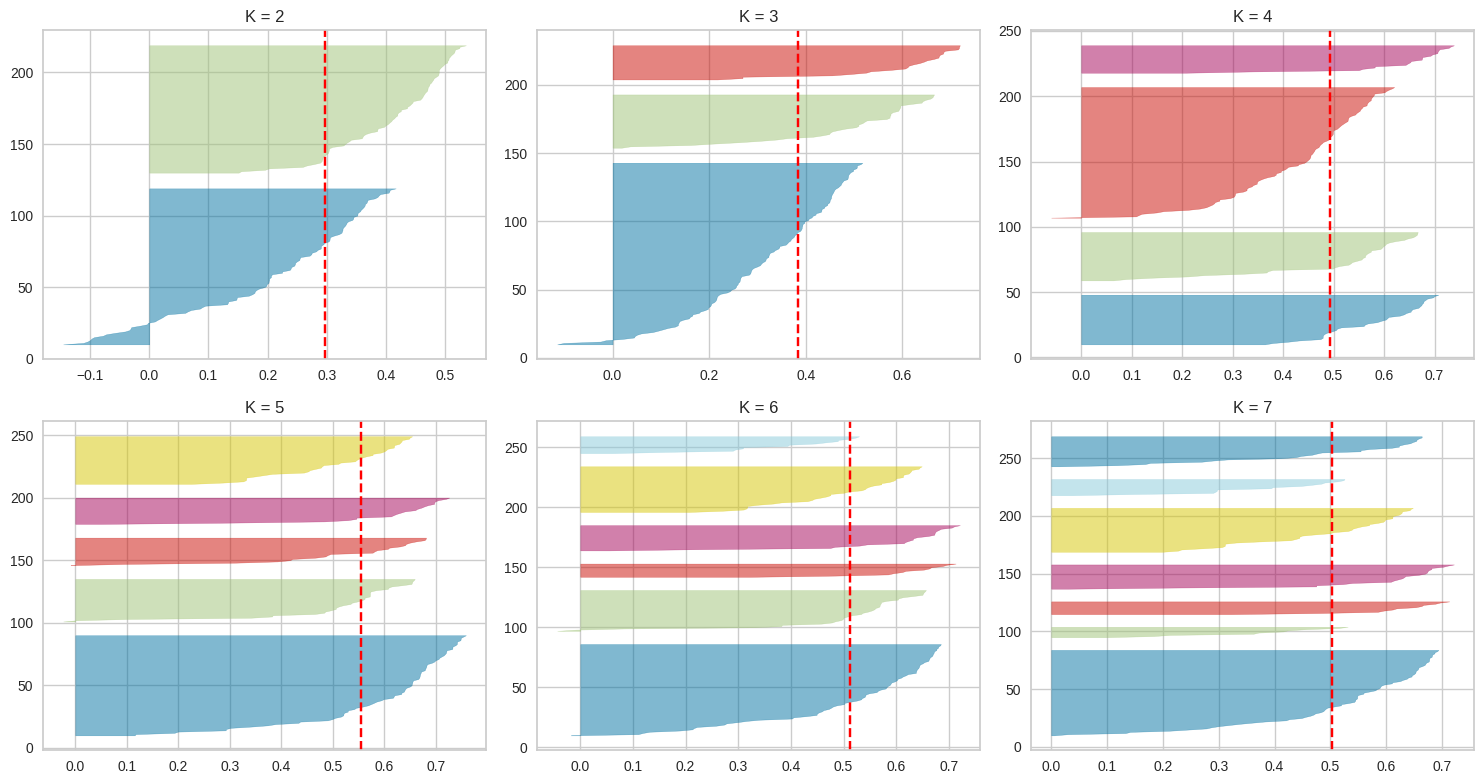

In [84]:
# Set up subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Loop melalui setiap subplot
for i, ax in enumerate(axes.flatten()):
    # Set jumlah cluster
    n_clusters = i + 2

    # Initialize K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++",
                    n_init = 'auto', max_iter = 100, random_state = 42)

    # Buat SilhouetteVisualizer
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax)

    # Fit visualizer ke data x
    visualizer.fit(x)

    # Set title
    ax.set_title(f'K = {n_clusters}')

# Adjust layout
plt.tight_layout()
plt.show()

In [85]:
km = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300,
            n_init = 'auto', random_state = 3)
y_pred = km.fit_predict(x)
y_pred

array([2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 0,
       2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 1, 0, 1, 4, 1, 4, 1,
       0, 1, 4, 1, 4, 1, 4, 1, 4, 1, 0, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1,
       4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1,
       4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1,
       4, 1], dtype=int32)

In [86]:
#gabungkan hasil clustering dengan dafarame x
x['cluster'] = list(y_pred)
x.head()

,spending_score,annual_income,cluster
0,39,15,2
1,81,15,3
2,6,16,2
3,77,16,3
4,40,17,2


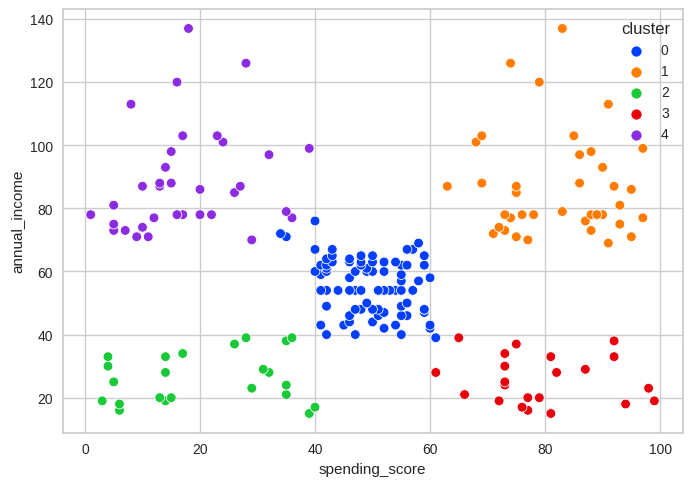

In [87]:
sns.scatterplot(data=x, x="spending_score", y="annual_income", hue="cluster",palette="bright");

In [88]:
for cluster_label in range(0, 5):
    cluster_data = x.query(f'cluster == {cluster_label}')
    spending_score_mean = cluster_data['spending_score'].mean().round(2)
    annual_income_mean = cluster_data['annual_income'].mean().round(2)
    print(f"Average Spending Score on Cluster {cluster_label}: {spending_score_mean}")
    print(f"Average Annual Income on Cluster {cluster_label}: {annual_income_mean}\n")

Average Spending Score on Cluster 0: 49.52
Average Annual Income on Cluster 0: 55.3

Average Spending Score on Cluster 1: 82.13
Average Annual Income on Cluster 1: 86.54

Average Spending Score on Cluster 2: 20.91
Average Annual Income on Cluster 2: 26.3

Average Spending Score on Cluster 3: 79.36
Average Annual Income on Cluster 3: 25.73

Average Spending Score on Cluster 4: 17.11
Average Annual Income on Cluster 4: 88.2



##### Fitting model into Inference Data

In [89]:
df_inter_no_pca = df_inter.loc[:, ['spending_score', 'annual_income']]

In [90]:
infer_no_pca = km.fit_predict(df_inter_no_pca)
infer_no_pca

array([2, 1, 1, 2, 1, 3, 3, 3, 4, 1, 0, 0, 2, 1, 3, 1, 1, 0, 4, 2, 4, 1,
       1, 1, 3, 1, 4, 3, 3, 1, 3, 2, 0, 0, 0, 1, 4, 3, 0, 1, 1, 3, 1, 1,
       0, 3, 0, 2, 1, 0, 3, 0, 3, 3, 4, 0, 3, 2, 0, 3, 4, 1, 4, 1, 0, 3,
       3, 1, 1, 0, 0, 1, 2, 4, 1, 1, 3, 1, 4, 3, 1, 0, 1, 4, 4, 0, 4, 3,
       0, 0, 2, 2, 3, 2, 4, 2, 1, 0, 0, 1, 2, 4, 1, 3, 4, 2, 0, 3, 1, 1,
       3, 1, 2, 3, 1, 2, 1, 1, 4, 2, 2, 3, 3, 4, 4, 1, 1, 3, 1, 0, 0, 0,
       4, 1, 2, 3, 1, 4, 4, 3], dtype=int32)

In [91]:
df_inter_no_pca['cluster'] = list(infer_no_pca)
df_inter_no_pca.head()

,spending_score,annual_income,cluster
0,91,27,2
1,22,38,1
2,9,21,1
3,97,26,2
4,20,59,1


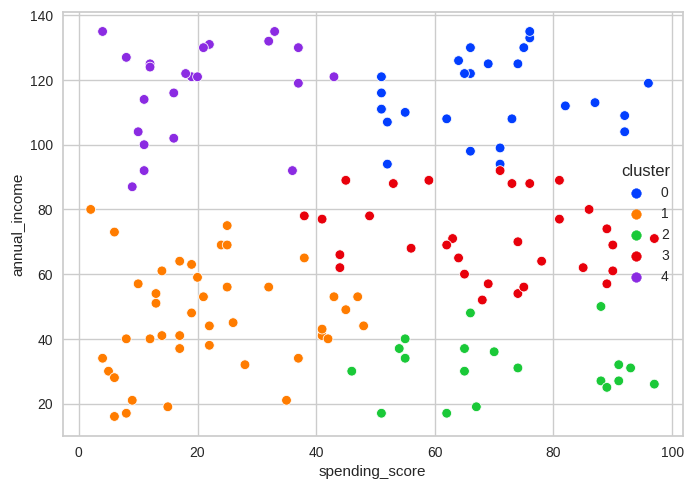

In [92]:
sns.scatterplot(data=df_inter_no_pca, x="spending_score", y="annual_income", hue="cluster",palette="bright");

In [93]:
for cluster_label in range(0, 5):
    cluster_data = df_inter_no_pca.query(f'cluster == {cluster_label}')
    spending_score_mean = cluster_data['spending_score'].mean().round(2)
    annual_income_mean = cluster_data['annual_income'].mean().round(2)
    print(f"Average Spending Score on Cluster {cluster_label}: {spending_score_mean}")
    print(f"Average Annual Income on Cluster {cluster_label}: {annual_income_mean}\n")

Average Spending Score on Cluster 0: 68.69
Average Annual Income on Cluster 0: 114.69

Average Spending Score on Cluster 1: 21.93
Average Annual Income on Cluster 1: 46.52

Average Spending Score on Cluster 2: 71.95
Average Annual Income on Cluster 2: 31.26

Average Spending Score on Cluster 3: 68.68
Average Annual Income on Cluster 3: 71.65

Average Spending Score on Cluster 4: 19.91
Average Annual Income on Cluster 4: 117.27



#### Model : Clustering with PCA

In [94]:
df_new = df_copy.iloc[:,2:]
df_new

,age,annual_income,spending_score
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40
...,...,...,...
195,35,120,79
196,45,126,28
197,32,126,74
198,32,137,18


In [95]:
# Feature Scaling
df_new_scale = StandardScaler().fit_transform(df_new)

In [96]:
# Cek Variance dengan PCA
%%time
pca = PCA()
pca.fit(df_new_scale)

CPU times: user 1.16 ms, sys: 22 µs, total: 1.18 ms
Wall time: 1.19 ms


PCA()

In [97]:
# Cek jumlah komponen jika kita ingin menyimpan 70% informasi

cumsum = np.cumsum(pca.explained_variance_ratio_)
num_com = np.argmax(cumsum >= 0.7) + 1
num_com

2

In [98]:
# Gunakan n_components=2
pca = PCA(n_components=2)

reduced_data = pca.fit_transform(df_new_scale)

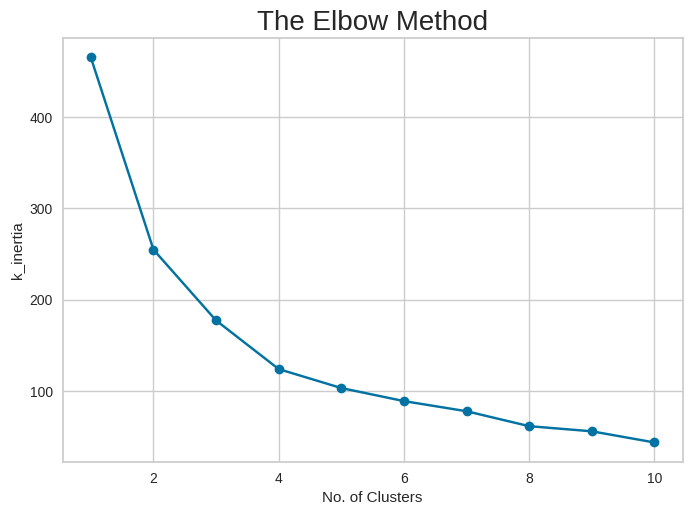

In [99]:
k_inertia = []
#membuat iterasi dari 1-10 untuk nilai k terbaik
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 'auto', random_state = 3)
    km.fit(reduced_data)
    k_inertia.append(km.inertia_)

plt.plot(range(1, 11), k_inertia, marker ="o")
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('k_inertia')
plt.show()

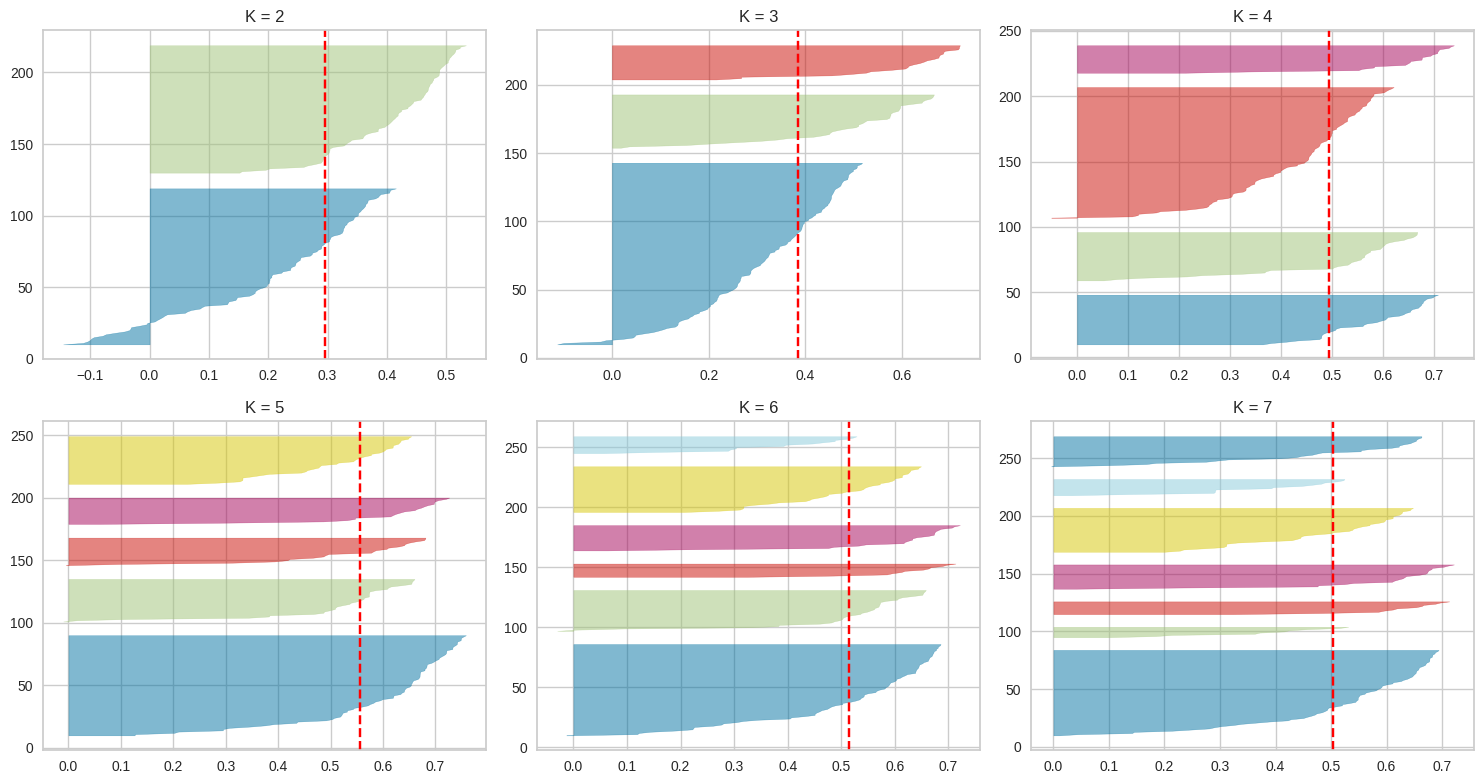

In [100]:
# Set up subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Loop melalui setiap subplot
for i, ax in enumerate(axes.flatten()):
    # Set jumlah cluster
    n_clusters = i + 2

    # Initialize K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++",
                    n_init = 'auto', max_iter = 100, random_state = 42)

    # Buat SilhouetteVisualizer
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax)

    # Fit visualizer ke data x
    visualizer.fit(x)

    # Set title
    ax.set_title(f'K = {n_clusters}')

# Adjust layout
plt.tight_layout()
plt.show()

In [101]:
km = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 'auto', random_state = 3)
km.fit(reduced_data)

KMeans(n_clusters=5, n_init='auto', random_state=3)

In [102]:
clusters = km.predict(reduced_data)
clusters

array([2, 2, 3, 2, 2, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2,
       3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2,
       3, 2, 3, 2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 0, 3, 2,
       0, 3, 2, 2, 3, 0, 3, 0, 0, 2, 0, 0, 2, 0, 0, 0, 3, 0, 2, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1,
       4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1,
       4, 1], dtype=int32)

In [103]:
reduced_data= pd.DataFrame(reduced_data, columns= ['PC1','PC2'])
reduced_data.head()

,PC1,PC2
0,-0.615720,-1.763481
1,-1.665793,-1.820747
2,0.337862,-1.674799
3,-1.456573,-1.772430
4,-0.038465,-1.662740


In [104]:
reduced_data['cluster'] = clusters
reduced_data.head()

,PC1,PC2,cluster
0,-0.615720,-1.763481,2
1,-1.665793,-1.820747,2
2,0.337862,-1.674799,3
3,-1.456573,-1.772430,2
4,-0.038465,-1.662740,2


In [105]:
pca_df_cluster = pd.concat([df_new, reduced_data], axis=1)
pca_df_cluster.head()

,age,annual_income,spending_score,PC1,PC2,cluster
0,19,15,39,-0.615720,-1.763481,2
1,21,15,81,-1.665793,-1.820747,2
2,20,16,6,0.337862,-1.674799,3
3,23,16,77,-1.456573,-1.772430,2
4,31,17,40,-0.038465,-1.662740,2


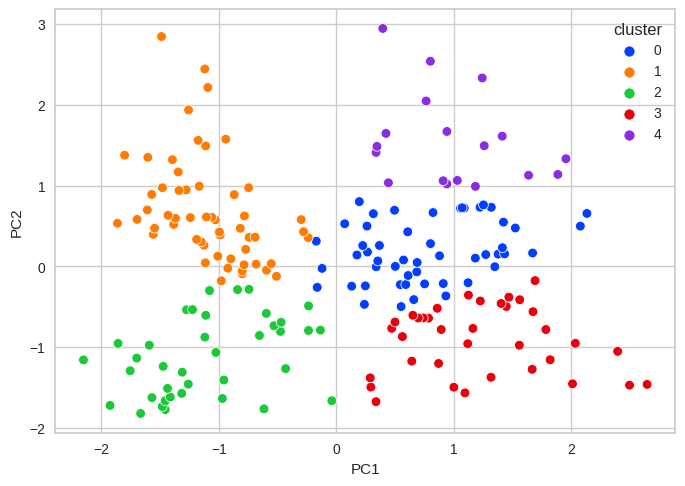

In [106]:
sns.scatterplot(data=pca_df_cluster, x="PC1", y="PC2", hue="cluster",palette="bright");

In [107]:
label_df= pca_df_cluster['cluster'].unique()
label_df

array([2, 3, 0, 1, 4], dtype=int32)

In [108]:
for cluster_label in range(0, 5):
    cluster_data = pca_df_cluster.query(f'cluster == {cluster_label}')
    spending_score_mean = cluster_data['spending_score'].mean().round(2)
    annual_income_mean = cluster_data['annual_income'].mean().round(2)
    print(f"Average Spending Score on Cluster {cluster_label}: {spending_score_mean}")
    print(f"Average Annual Income on Cluster {cluster_label}: {annual_income_mean}\n")

Average Spending Score on Cluster 0: 37.75
Average Annual Income on Cluster 0: 64.54

Average Spending Score on Cluster 1: 71.52
Average Annual Income on Cluster 1: 79.61

Average Spending Score on Cluster 2: 67.5
Average Annual Income on Cluster 2: 32.63

Average Spending Score on Cluster 3: 31.92
Average Annual Income on Cluster 3: 35.0

Average Spending Score on Cluster 4: 19.89
Average Annual Income on Cluster 4: 99.89



### Conclusion
Jika kita melihat pengclusteran yang ada, terdapat 5 cluster yang terbentuk. Dari 5 cluster tersebut, kita dapat memberikan program per clusternya yakni sebagai berikut.
- Cluster dengan Spending Score Sangat Kecil, namun Annual Income Besar (Cluster A)
- Cluster dengan Spending Score Sangat Kecil dan Annual Income Kecil (Cluster B)
- Cluster dengan Spending Score Sangat Besar dan Annual Income Besar (Cluster C)
- Cluster dengan Spending Score Sangat Besar, namun Annual Income Kecil (Cluster D)
- Cluster dengan Spending Score dan Annual Income yang sebanding (Cluster E)

### Suggestion
- Untuk Cluster A, kita harus mencari tau terlebih dahulu mengapa orang-orang yang memiliki pemasukan tahunan yang besar tetapi tidak banyak melakukan pembelian. Kita dapat memeriksa apakah Pelayanan yang diberikan oleh Supermarket kurang kah? Atau barang-barang yang ada tidak sesuai ekspektasi kah? Hal tersebut yang harus ditelusuri lebih lanjut
- Untuk Cluster B, Kita dapat memberikan program diskon untuk barang-barang tertentu agar dapat menyesuaikan dengan pemasukan tahunan yang dimiliki oleh Cluster B. Namun tidak disarankan untuk fokus kepada orang-orang di Cluster B ini
- Untuk Cluster C, Kita dapat terus gencar memberikan informasi barang-barang yang bagus dan promosi kepada Cluster ini
- Untuk Cluster D, Kita tetap dapat pempromosikan barang-barang kita serta memberikan banyak diskon kepada mereka karena telah menggunakan layanan supermarket kita
- Untuk Cluster E, Tidak disarankan untuk fokus kepada orang-orang di Cluster ini tetapi dikarenakan pengeluaran dan pemasukan yang sebanding, kita masih dapat memberikan promosi yang baik kepada mereka mengingat mereka akan membeli sesuai dengan pemasukan yang mereka dapatkan tiap tahunnya.